### Notebook helper function for pretty output

# cyano-PS1 case study estimate scaling with equal area penalty

In [120]:
from IPython.display import Markdown, display


def print_md(markdown_printable):
    """Pretty render Markdown."""
    display(Markdown(str(markdown_printable)))


def print_yaml_file(file_path):
    """Pretty render yaml file."""
    with open(file_path) as f:
        print_md(f"```yaml\n{f.read()}\n```")

### Plotting functions ([`pyglotaran_extras`](https://github.com/s-weigand/pyglotaran-extras/commit/20da3593105fb839f86e668dc12dc9ca87c3b9ce) + `matplotlib`)

In [121]:
import matplotlib.pyplot as plt
from pyglotaran_extras.plotting.plot_overview import plot_overview
from pyglotaran_extras.plotting.plot_svd import plot_svd
from pyglotaran_extras.plotting.style import PlotStyle

plot_style = PlotStyle()
plt.rc("axes", prop_cycle=plot_style.cycler)
plt.rcParams["figure.figsize"] = (21, 14)

### Analysis functions

In [122]:
from glotaran.analysis.optimize import optimize
from glotaran.io import load_dataset, load_model, load_parameters
from glotaran.project.scheme import Scheme

### Read data

In [123]:
dataset = load_dataset("streakdata.ascii")
dataset

<xarray.Dataset>
Dimensions:                      (left_singular_value_index: 49, right_singular_value_index: 49, singular_value_index: 49, spectral: 49, time: 923)
Coordinates:
  * time                         (time) float64 -101.0 -100.8 ... 99.24 99.46
  * spectral                     (spectral) float64 626.1 629.5 ... 785.3 788.7
Dimensions without coordinates: left_singular_value_index, right_singular_value_index, singular_value_index
Data variables:
    data                         (time, spectral) float64 50.75 59.21 ... 113.1
    data_left_singular_vectors   (time, left_singular_value_index) float64 -0...
    data_singular_values         (singular_value_index) float64 2.802e+05 ......
    data_right_singular_vectors  (right_singular_value_index, spectral) float64 ...

## Target analysis

Theoretical background from ``compartmental_models.pdf``

![model_sheme](target_scheme.jpg)


Concentration vector

$$c(t)= \begin{bmatrix} S(t) & B(t) & R_1(t) & R_2(t) & F(t)\end{bmatrix}^T$$

The concentration function correspond to

| ***Function name***    | ***S(t)***   | ***B(t)***   | ***R_1(t)***   | ***R_2(t)***   | ***F(t)***   |
|------------------------|--------------|--------------|----------------|----------------|--------------|
| **Name in the schema** | Soret        | Bulk         | Red1           | Red2           | Free         |


Differential equation

$$\dfrac{\mathrm{d}}{\mathrm{dt}}c(t) = \mathbf{K}c(t)+j(t)$$

Input function

$$j(t) = i(t) \begin{bmatrix} 1&0&0&0&0\end{bmatrix}^T$$

Transfer maxtrix $\mathbf{K}$

$$
\mathbf{K} = \begin{bmatrix} 
    -(k_{21} + k_{31} + k_{41} + k_{51}) &                          &                   &                  &       \\ 
    k_{21}                               & -(k_T + k_{32} + k_{42}) & k_{23}            & k_{24}           &       \\
    k_{31}                               &  k_{32}                  & -(k_{F} + k_{23}) &                  &       \\
    k_{41}                               &  k_{42}                  &                   & -(k_{F} + k_{24}) &      \\
    k_{51}                               &                          &                   &                  & k_{F} \\
    \end{bmatrix}
$$

- $k_T$: effective rate constantof Chl, T stands for photochemical Trapping of the excitation energy
- $k_F$: natural decay rate of free Chl, F stands for Fluorescence

### Reduced K-matrix

$$
\mathbf{K} = \begin{bmatrix} 
           &        &        &        &       \\ 
    k_{21} & k_T    & k_{23} & k_{24} &       \\
    k_{31} & k_{32} & k_{F}  &        &       \\
    k_{41} & k_{42} &        & k_{F}  &       \\
    k_{51} &        &        &        & k_{F} \\
    \end{bmatrix}
$$

### Reduced K-matrix ignoring input to Red1 and Red2

$$
\mathbf{K} = \begin{bmatrix} 
           &        &        &        &       \\ 
    k_{21} & k_T    & k_{23} & k_{24} &       \\
           & k_{32} & k_{F}  &        &       \\
           & k_{42} &        & k_{F}  &       \\
    k_{51} &        &        &        & k_{F} \\
    \end{bmatrix}
$$

With the rate relations:

- $k_{23} = a_1~k_{32}$
- $k_{24} = a_2~k_{42}$

### equal_area-target-model.yml

In [124]:
print_yaml_file("models/equal_area-target-model.yml")

```yaml
type: kinetic-spectrum

megacomplex:
  mc1:
    k_matrix: [km1]

k_matrix:
  km1:
    matrix:
      (s2, s1): kinetic.1
      (s5, s1): kinetic.2
      (s2, s2): kinetic.3
      (s3, s2): kinetic.4
      (s4, s2): kinetic.5
      (s2, s3): kinetic.7
      (s3, s3): kinetic.6
      (s2, s4): kinetic.8
      (s4, s4): kinetic.6
      (s5, s5): kinetic.6
      
spectral_constraints:
  - type: zero
    compartment: s1
    interval:
      - [100, 1000]
  - type: zero
    compartment: s3
    interval:
      - [100, 680]
  - type: zero
    compartment: s4
    interval:
      - [100, 690]
    

equal_area_penalties:
  - type: equal_area
    source: s5
    source_intervals: [[0, 1000]]
    target: s2
    target_intervals: [[0, 1000]]
    parameter: area.1
    weight: 0.1
  - type: equal_area
    source: s2
    source_intervals: [[0, 1000]]
    target: s3
    target_intervals: [[0, 1000]]
    parameter: area.1
    weight: 0.1
  - type: equal_area
    source: s3
    source_intervals: [[0, 1000]]
    target: s4
    target_intervals: [[0, 1000]]
    parameter: area.1
    weight: 0.1
      
      
irf:
  irf1:
    type: gaussian
    center: irf.center
    width: irf.width
    backsweep: True
    backsweep_period: irf.backsweep


initial_concentration:
  input1:
    compartments: [s1, s2, s3, s4, s5]
    parameters: [
      input.1,
      input.0,
      input.0,
      input.0,
      input.0]


dataset:
  dataset1:
    initial_concentration: input1
    megacomplex: [mc1]
    irf: irf1
```

### equal_area-target-parameters.yml

In [125]:
print_yaml_file("models/equal_area-target-parameters.yml")

```yaml
input:
  - ["1", 1]
  - ["0", 0]
  - {vary: false}

irf:
  - ["center", -84.0]
  - ["width", 1.6]
  - ["backsweep", 13800.0, {vary: false}]

kinetic:
  - [2, {vary: false}]
  - [0.1, {vary: false}]
  - 0.05
  - 0.1
  - 0.03
  - 0.00016
  - ["7", {expr: '$kinetic.4 * $scaling.1'}]
  - ["8", {expr: '$kinetic.5 * $scaling.2'}]
  
  
scaling:
#   - 1.87
#   - 1.37
  - 1.5
  - 1
  

area:
  - ['1', 1, {"vary": False}]
```

In [126]:
target_model = load_model("models/equal_area-target-model.yml")
target_parameters = load_parameters("models/equal_area-target-parameters.yml")
print_md(target_model.validate(parameters=target_parameters))

Your model is valid.

In [127]:
print_md(target_model)

# Model

_Type_: kinetic-spectrum

## Initial Concentration

* **input1**:
  * *Label*: input1
  * *Compartments*: ['s1', 's2', 's3', 's4', 's5']
  * *Parameters*: [input.1, input.0, input.0, input.0, input.0]
  * *Exclude From Normalize*: []

## K Matrix

* **km1**:
  * *Label*: km1
  * *Matrix*: 
    * *('s2', 's1')*: kinetic.1
    * *('s5', 's1')*: kinetic.2
    * *('s2', 's2')*: kinetic.3
    * *('s3', 's2')*: kinetic.4
    * *('s4', 's2')*: kinetic.5
    * *('s2', 's3')*: kinetic.7
    * *('s3', 's3')*: kinetic.6
    * *('s2', 's4')*: kinetic.8
    * *('s4', 's4')*: kinetic.6
    * *('s5', 's5')*: kinetic.6
  

## Irf

* **irf1** (gaussian):
  * *Label*: irf1
  * *Type*: gaussian
  * *Center*: irf.center
  * *Width*: irf.width
  * *Normalize*: True
  * *Backsweep*: True
  * *Backsweep Period*: irf.backsweep

## Dataset

* **dataset1**:
  * *Label*: dataset1
  * *Megacomplex*: ['mc1']
  * *Initial Concentration*: input1
  * *Irf*: irf1

## Megacomplex

* **mc1**:
  * *Label*: mc1
  * *K Matrix*: ['km1']

## Equal Area Penalties

* 
  * *Source*: s5
  * *Source Intervals*: [[0, 1000]]
  * *Target*: s2
  * *Target Intervals*: [[0, 1000]]
  * *Parameter*: area.1
  * *Weight*: 0.1
* 
  * *Source*: s2
  * *Source Intervals*: [[0, 1000]]
  * *Target*: s3
  * *Target Intervals*: [[0, 1000]]
  * *Parameter*: area.1
  * *Weight*: 0.1
* 
  * *Source*: s3
  * *Source Intervals*: [[0, 1000]]
  * *Target*: s4
  * *Target Intervals*: [[0, 1000]]
  * *Parameter*: area.1
  * *Weight*: 0.1

## Spectral Constraints

* **zero**:
  * *Type*: zero
  * *Compartment*: s1
  * *Interval*: [[100, 1000]]
* **zero**:
  * *Type*: zero
  * *Compartment*: s3
  * *Interval*: [[100, 680]]
* **zero**:
  * *Type*: zero
  * *Compartment*: s4
  * *Interval*: [[100, 690]]



### Create scheme and optimize it

In [128]:
target_scheme = Scheme(
    target_model,
    target_parameters,
    {"dataset1": dataset},
    non_negative_least_squares=True,
)
target_result = optimize(target_scheme)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2714e+08                                    2.71e+11    
       1              2         8.4725e+07      1.42e+08       3.57e-01       4.17e+10    
       2              3         6.2918e+07      2.18e+07       3.59e-01       9.97e+08    
       3              4         5.2351e+07      1.06e+07       3.94e-01       5.14e+10    
       4              5         4.9128e+07      3.22e+06       2.59e-01       3.30e+10    
       5              7         4.7872e+07      1.26e+06       1.18e-01       4.64e+09    
       6              8         4.7496e+07      3.77e+05       2.36e-01       1.44e+10    
       7              9         4.7222e+07      2.74e+05       1.43e-01       2.44e+09    
       8             10         4.7173e+07      4.92e+04       4.71e-02       3.46e+08    
       9             11         4.7170e+07      2.39e+03       1.71e-02       3.46e+08    

In [129]:
target_result.data["dataset1"]

<xarray.Dataset>
Dimensions:                                   (clp_label: 5, component: 5, from_species: 5, left_singular_value_index: 49, right_singular_value_index: 49, singular_value_index: 49, species: 5, spectral: 49, time: 923, to_species: 5)
Coordinates:
  * time                                      (time) float64 -101.0 ... 99.46
  * spectral                                  (spectral) float64 626.1 ... 788.7
  * clp_label                                 (clp_label) <U2 's1' 's2' ... 's5'
  * species                                   (species) <U2 's1' 's2' ... 's5'
    rate                                      (component) float64 -2.1 ... -0...
    lifetime                                  (component) float64 -0.4762 ......
  * to_species                                (to_species) <U2 's1' ... 's5'
  * from_species                              (from_species) <U2 's1' ... 's5'
Dimensions without coordinates: component, left_singular_value_index, right_singular_value_index, singular_value_index
Data variables: (12/24)
    data                                      (time, spectral) float64 50.75 ...
    data_left_singular_vectors                (time, left_singular_value_index) float64 ...
    data_singular_values                      (singular_value_index) float64 ...
    data_right_singular_vectors               (right_singular_value_index, spectral) float64 ...
    matrix                                    (spectral, time, clp_label) float64 ...
    clp                                       (spectral, clp_label) float64 0...
    ...                                        ...
    a_matrix                                  (component, species) float64 1....
    k_matrix                                  (to_species, from_species) float64 ...
    k_matrix_reduced                          (to_species, from_species) float64 ...
    irf_center                                float64 -84.24
    irf_width                                 float64 1.612
    irf                                       (time) float64 3.842e-24 ... 0.0
Attributes:
    root_mean_square_error:           45.27854942743579
    weighted_root_mean_square_error:  45.27854942743579

### Result plots

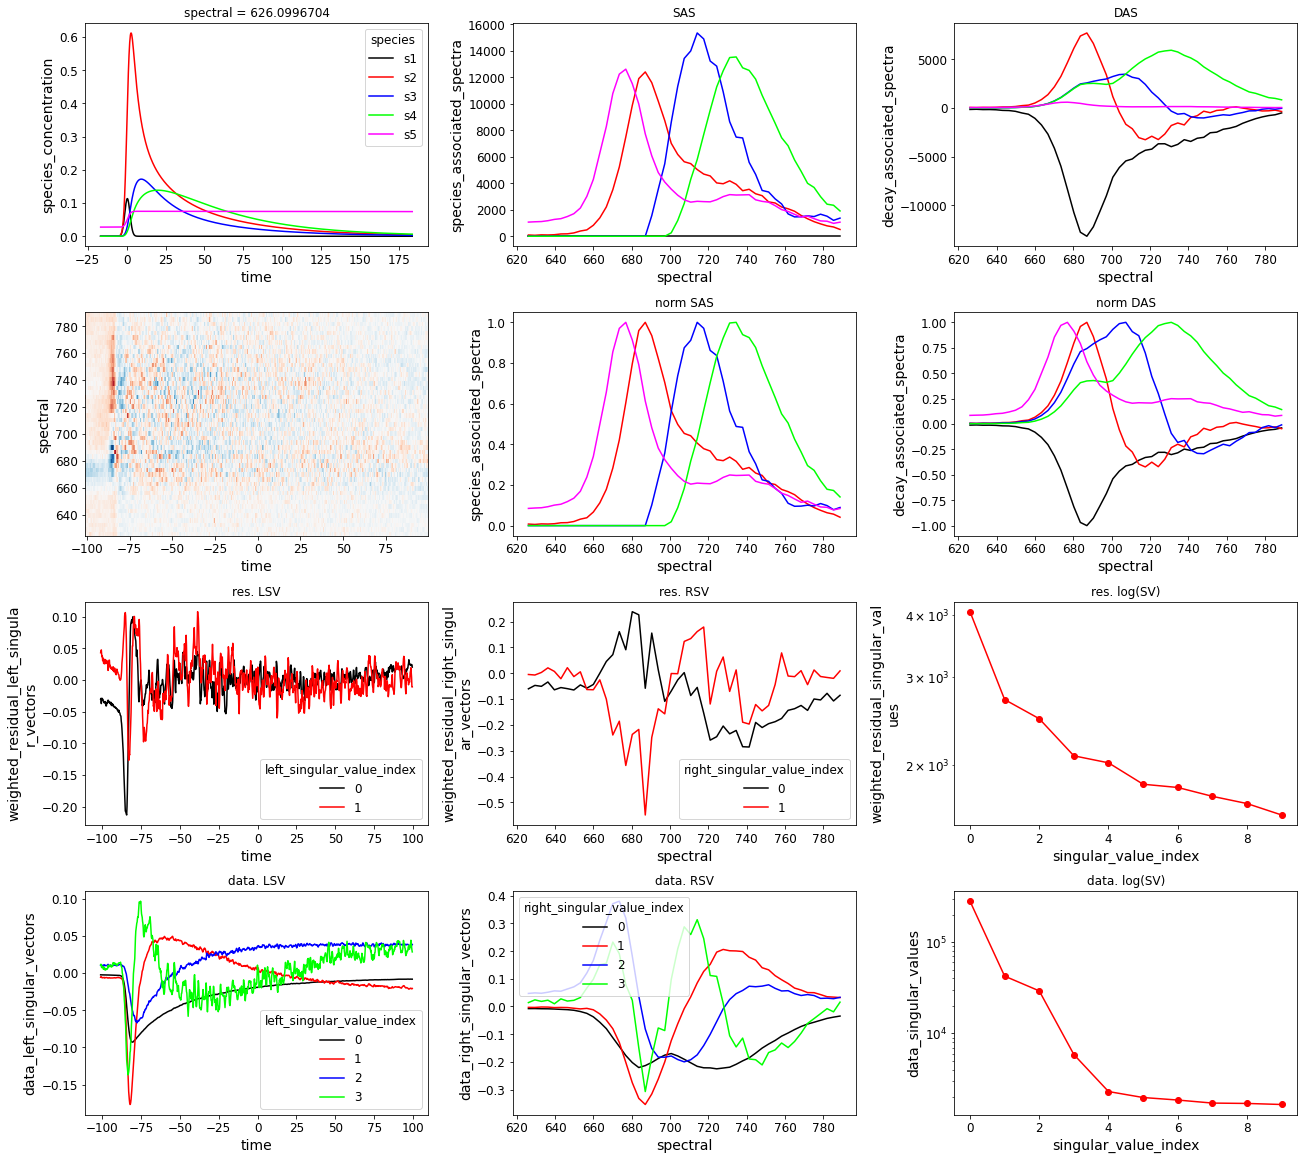

In [135]:
fig = plot_overview(target_result.data["dataset1"], linlog=False)

In [131]:
print_md(target_result.optimized_parameters)

  * __area__:

    |   _Label_ |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    |         1 |         1 |          0 |    -inf |     inf | False    | False            | None     |

  * __input__:

    |   _Label_ |   _Value_ |   _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|------------|---------|---------|----------|------------------|----------|
    |         1 |         1 |          0 |    -inf |     inf | False    | False            | None     |
    |         0 |         0 |          0 |    -inf |     inf | False    | False            | None     |

  * __irf__:

    | _Label_   |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-------------|-------------|---------|---------|----------|------------------|----------|
    | center    |   -84.2402  | 4.38314e-05 |    -inf |     inf | True     | False            | None     |
    | width     |     1.61181 | 6.06638e-05 |    -inf |     inf | True     | False            | None     |
    | backsweep | 13800       | 0           |    -inf |     inf | False    | False            | None     |

  * __kinetic__:

    |   _Label_ |     _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_                  |
    |-----------|-------------|-------------|---------|---------|----------|------------------|-------------------------|
    |         1 | 2           | 0           |    -inf |     inf | False    | False            | None                    |
    |         2 | 0.1         | 0           |    -inf |     inf | False    | False            | None                    |
    |         3 | 0.0642032   | 2.56716e-06 |    -inf |     inf | True     | False            | None                    |
    |         4 | 0.0660468   | 9.71655e-06 |    -inf |     inf | True     | False            | None                    |
    |         5 | 0.0293715   | 7.07843e-06 |    -inf |     inf | True     | False            | None                    |
    |         6 | 0.000145518 | 1.27786e-08 |    -inf |     inf | True     | False            | None                    |
    |         7 | 0.132201    | 0           |    -inf |     inf | False    | False            | $kinetic.4 * $scaling.1 |
    |         8 | 0.0406569   | 0           |    -inf |     inf | False    | False            | $kinetic.5 * $scaling.2 |

  * __scaling__:

    |   _Label_ |   _Value_ |    _StdErr_ |   _Min_ |   _Max_ | _Vary_   | _Non-Negative_   | _Expr_   |
    |-----------|-----------|-------------|---------|---------|----------|------------------|----------|
    |         1 |   2.00162 | 0.000382471 |    -inf |     inf | True     | False            | None     |
    |         2 |   1.38423 | 0.000199601 |    -inf |     inf | True     | False            | None     |

